In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
from PIL import Image
from IPython.display import display

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

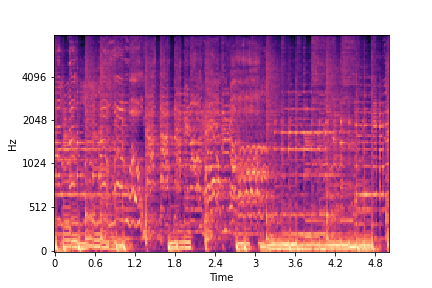

(432, 288)


In [3]:
# try to get one of the images inside the file
with Image.open('SplitmelSpect/train/rock/11.png') as im:
    display(im)
    print(im.size)

In [4]:
transform = transforms.ToTensor()
root ="SplitmelSpect"

train_data = datasets.ImageFolder(os.path.join(root,"train"), transform= transform)
test_data = datasets.ImageFolder(os.path.join(root, "test"), transform = transform)

torch.manual_seed(30)

train_loader = DataLoader(train_data, batch_size=10,shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

class_names = train_data.classes

In [5]:
class_names

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

In [6]:
len(train_data)

1797

In [7]:
len(test_data)

1200

Labels:  [3 2 7 5 3 0 8 1 5 1]
Class:  disco country pop jazz disco blues reggae classical jazz classical


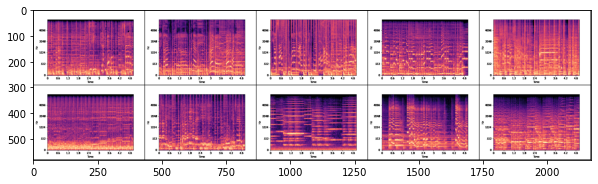

In [8]:
## A table of the labelled data to images
for images, labels in train_loader:
    break
    

print('Labels: ', labels.numpy())
print('Class: ',*np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [9]:
images[0].shape

torch.Size([3, 288, 432])

In [10]:
print((((288-2)/2)-2)/2)
print(((430/2)-2)/2)
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, 1)  
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(70*106*16, 1024)   
        self.fc2 = nn.Linear(1024,108)
        self.fc3 = nn.Linear(108, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1,70*106*16) # flatten
#        X = F.dropout(X,p=0.4)
        X = F.relu(self.fc1(X))
#        X = F.dropout(X, p=0.4)
        X = F.relu(self.fc2(X))
#        X = F.dropout(X,p=0.4)
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

70.5
106.5


In [11]:
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=118720, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=108, bias=True)
  (fc3): Linear(in_features=108, out_features=10, bias=True)
)

In [12]:
for param in model.parameters():
    print(param.numel())

450
6
864
16
121569280
1024
110592
108
1080
10


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001) ## stochiastic gradient descent

In [14]:
import time
start_time = time.time()

epochs = 15

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
       
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print results
        if b%10 == 0:
            print(f'epoch: {i:4}  batch: {b:4}  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss.data.item())
    train_correct.append(trn_corr)


    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss.data.item())
    test_correct.append(tst_corr)
    print('Validation accuracy at the end of this epoch: ' + str(tst_corr.item()*100/1200))

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed   

epoch:    0  batch:   10  loss: 2.50229287  accuracy:  10.000%
epoch:    0  batch:   20  loss: 2.44827437  accuracy:   8.500%
epoch:    0  batch:   30  loss: 2.32429647  accuracy:   9.000%
epoch:    0  batch:   40  loss: 2.33130002  accuracy:  10.250%
epoch:    0  batch:   50  loss: 2.32631445  accuracy:  10.200%
epoch:    0  batch:   60  loss: 2.33720350  accuracy:  10.500%
epoch:    0  batch:   70  loss: 2.31033373  accuracy:  10.286%
epoch:    0  batch:   80  loss: 2.22225761  accuracy:  12.125%
epoch:    0  batch:   90  loss: 2.28778791  accuracy:  12.556%
epoch:    0  batch:  100  loss: 2.18492389  accuracy:  13.200%
epoch:    0  batch:  110  loss: 2.24305749  accuracy:  13.727%
epoch:    0  batch:  120  loss: 2.36137056  accuracy:  14.417%
epoch:    0  batch:  130  loss: 2.27799463  accuracy:  15.308%
epoch:    0  batch:  140  loss: 2.03255129  accuracy:  15.857%
epoch:    0  batch:  150  loss: 2.39027262  accuracy:  16.467%
epoch:    0  batch:  160  loss: 2.15521240  accuracy:  

epoch:    6  batch:  180  loss: 0.06907509  accuracy:  95.833%
Validation accuracy at the end of this epoch: 54.5
epoch:    7  batch:   10  loss: 0.04920864  accuracy: 100.000%
epoch:    7  batch:   20  loss: 0.01698053  accuracy: 100.000%
epoch:    7  batch:   30  loss: 0.03495793  accuracy: 100.000%
epoch:    7  batch:   40  loss: 0.07781309  accuracy: 100.000%
epoch:    7  batch:   50  loss: 0.03190984  accuracy:  99.800%
epoch:    7  batch:   60  loss: 0.02787623  accuracy:  99.500%
epoch:    7  batch:   70  loss: 0.04414237  accuracy:  99.429%
epoch:    7  batch:   80  loss: 0.02302138  accuracy:  99.500%
epoch:    7  batch:   90  loss: 0.09625621  accuracy:  99.444%
epoch:    7  batch:  100  loss: 0.20811024  accuracy:  99.300%
epoch:    7  batch:  110  loss: 0.07638629  accuracy:  99.273%
epoch:    7  batch:  120  loss: 0.01140061  accuracy:  99.000%
epoch:    7  batch:  130  loss: 0.03739793  accuracy:  98.846%
epoch:    7  batch:  140  loss: 0.00663809  accuracy:  98.857%
epoc

epoch:   13  batch:  160  loss: 0.00047390  accuracy: 100.000%
epoch:   13  batch:  170  loss: 0.00021187  accuracy: 100.000%
epoch:   13  batch:  180  loss: 0.00009205  accuracy:  99.833%
Validation accuracy at the end of this epoch: 59.5
epoch:   14  batch:   10  loss: 0.00002829  accuracy: 100.000%
epoch:   14  batch:   20  loss: 0.00047833  accuracy: 100.000%
epoch:   14  batch:   30  loss: 0.00039109  accuracy: 100.000%
epoch:   14  batch:   40  loss: 0.00106038  accuracy: 100.000%
epoch:   14  batch:   50  loss: 0.00057545  accuracy: 100.000%
epoch:   14  batch:   60  loss: 0.00003582  accuracy: 100.000%
epoch:   14  batch:   70  loss: 0.00014279  accuracy: 100.000%
epoch:   14  batch:   80  loss: 0.00065126  accuracy: 100.000%
epoch:   14  batch:   90  loss: 0.00083694  accuracy: 100.000%
epoch:   14  batch:  100  loss: 0.00018873  accuracy: 100.000%
epoch:   14  batch:  110  loss: 0.00026414  accuracy: 100.000%
epoch:   14  batch:  120  loss: 0.00011248  accuracy: 100.000%
epoc

In [ ]:
torch.save(model.state.dict(), 'CNN Model')

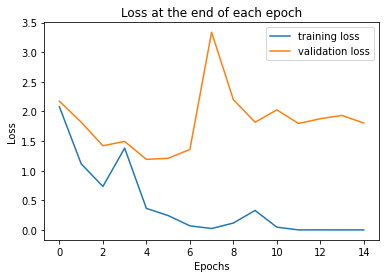

In [17]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss at the end of each epoch')
plt.legend()



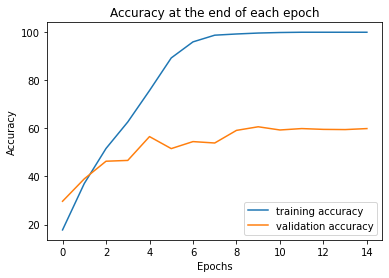

In [18]:
plt.plot([t.item()*100/1797 for t in train_correct], label='training accuracy')
plt.plot([t.item()*100/1200 for t in test_correct], label='validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Accuracy at the end of each epoch')
plt.legend();